# About timeline_viz.ipynb

This notebook uses the functions defined and demontrasted in *utils_timeline_viz.ipynb* to clean log data and visualize it.
This is a work in progress :)

In [1]:
exec(open('load_utils.py').read())
from utils_timeline_viz import *

importing notebook from utils_timeline_viz.ipynb
importing function: find_student_log_file
importing function: remove_model_events
importing function: calculate_duration
importing function: add_family
importing function: prep_parsing_data
importing function: get_blocks_withTime
importing function: plot_barGraph_new
importing function: action_usage
importing function: plot


In [2]:
def action_usage(df,column,regex):
    '''Given a regex, we detect its use using a particular column
    and then extract a list of time coordinates for when
    they were used. These coordinates are in the format (start_time, duration)
    
    Args:
        df (Pandas dataframe): The dataframe to search in.
        column (str): The column where the action regex might be logged (usualy the Family column)
        regex (str): The regex or often the name of the action family to search for in the column.    

    Returns:
        A list of tuples with start times of the regex and it's duration [(start1,duration1),(start2,duration2),...]
    '''
    if df[column].isnull().values.all():
        return [(0,0)]
    else:
        timecoords = zip(df[df[column].str.contains(regex,na=False)]['Time'],df[df[column].str.contains(regex,na=False)]['Duration'])
        return clean_coords(timecoords)

In [3]:
def get_record_usage(df):
    record_usage = action_usage(df,'Family','M')
    #We want record events ot be singular not episodes
    record_usage = [(time,2) for time,duration in record_usage]
    return record_usage

def axis_absorbance_usage(df):
    x_axis_usage = action_usage(df,'X axis','absorbance')
    y_axis_usage = action_usage(df,'Y axis','absorbance')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_trialNumber_usage(df):
    x_axis_usage = action_usage(df,'X axis','trialNumber')
    y_axis_usage = action_usage(df,'Y axis','trialNumber')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_width_usage(df):
    x_axis_usage = action_usage(df,'X axis','cuvetteWidth')
    y_axis_usage = action_usage(df,'Y axis','cuvetteWidth')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_concentration_usage(df):
    x_axis_usage = action_usage(df,'X axis','concentration')
    y_axis_usage = action_usage(df,'Y axis','concentration')
    return merge_usage(x_axis_usage,y_axis_usage)

def get_value_and_coords(df,variable):
    usage = action_usage(df,'Family',family_name_to_code[variable])
    values = list(df[df['Family'].str.contains(family_name_to_code[variable],na=False)][variable])
    coords = list(df[df['Family'].str.contains(family_name_to_code[variable],na=False)]['Time'])
    return values, coords, usage

def get_absorbance(df,_):
#     usage = action_usage(df,'Family',".*")
    values = list(df['Absorbance'])
    coords = list(df['Time'])
    return values, coords, None

def axis_absorbance_trialNumber_usage(df):
    absorbance = axis_absorbance_usage(df)
    trialNumber = axis_trialNumber_usage(df)
    return intersect_usage(absorbance,trialNumber)

def axis_absorbance_concentration_usage(df):
    absorbance = axis_absorbance_usage(df)
    concentration = axis_concentration_usage(df)
    return intersect_usage(absorbance,concentration)
    
def axis_absorbance_width_usage(df):
    absorbance = axis_absorbance_usage(df)
    width = axis_width_usage(df)
    return intersect_usage(absorbance,width)
    
def axis_other_usage(df):
    trialNumber = axis_trialNumber_usage(df)
    concentration = axis_concentration_usage(df)
    width = axis_width_usage(df)
    combo1 = intersect_usage(width,trialNumber)
    combo2 = intersect_usage(width,concentration)
    combo3 = intersect_usage(concentration,trialNumber)
    usage = merge_usage(combo1,combo2)
    return merge_usage(combo3,usage)

def axis_scale_log_usage(df):
    x_axis_usage = action_usage(df,'X axis scale','log')
    y_axis_usage = action_usage(df,'Y axis scale','log')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_scale_inverse_usage(df):
    x_axis_usage = action_usage(df,'X axis scale','inverse')
    y_axis_usage = action_usage(df,'Y axis scale','inverse')
    return merge_usage(x_axis_usage,y_axis_usage)

In [4]:
family_name_to_code = {'Interface':'I',
                        'Restore':'R',
                        'Pause':'P',
                        'Graph (add/del/edit)':'G',
                        'Data Table (del/move)':'Dt',
                        'Notes':'N',
                        'Record':'M',
                        'Detector':'Vd',
                        'Wavelength':'Vw',
                        'Width':'Vc',
                        'Concentration':'Vs',
                        'Laser toggle':'Vl',
                        }

function_to_use = {'Record':get_record_usage,
                    'Abs vs. TrialNumber':axis_absorbance_trialNumber_usage,
                   'Abs vs. Concentration':axis_absorbance_concentration_usage,
                   'Abs vs. Width':axis_absorbance_width_usage,
                   'Other axes':axis_other_usage,
                   'Log axis':axis_scale_log_usage,
                   'Inverse axis':axis_scale_inverse_usage,
                  'Wavelength':get_value_and_coords,
                  'Width':get_value_and_coords,
                  'Concentration':get_value_and_coords,
                   'Absorbance':get_absorbance,
                  'Laser toggle':get_value_and_coords}

colors = {'Interface':'#2a2d34',
            'Notes':'#f1cb2d',
            'Pause':'#f1cb2d',
            '':'white',
            'Log axis':'#2a2d34',
            'Inverse axis':'#2a2d34',
            'Other axes':'#2a2d34',
            'Abs vs. TrialNumber':'#4a000b',
            'Abs vs. Width':'#f1cb2d',
            'Abs vs. Concentration':'#5c8dfc',
            'Graph (add/del/edit)':'#2a2d34',
            '':'white',
            'Restore':'#6000fc',
            'Data Table (del/move)':'#6000fc',
            '':'white',
            'Record':'#6000fc',
            'Detector':'#32883b',
            'Wavelength':'#9b0017',
            'Width': '#ec7d27',
            'Concentration':'#5c8dfc',
            'Laser toggle':'#e90023',
            'Absorbance':'#2a2d34'}

to_plot = ['Interface','Notes','Pause','','Log axis','Inverse axis','Other axes','Abs vs. TrialNumber','Abs vs. Width','Abs vs. Concentration','Graph (add/del/edit)','','Restore','Data Table (del/move)','','Record','Detector','Wavelength','Width','Concentration','Laser toggle','Absorbance']

In [5]:
MIN_MAX = {'Wavelength':(380,780),
           'Width':(0.5,2.0),
           'Concentration':(0.0,200.0),
           'Absorbance':(0.0,3.84),
          'Laser toggle':(0.0,1.0)}


from matplotlib.ticker import MultipleLocator

from itertools import chain, izip
def fix_laser(values,coords):
    opp = [0.0 if v == 1.0 else 1.0 for v in values]
    newvalues = list(chain.from_iterable(izip(values,opp)))
    newcoords = list(chain.from_iterable(izip(coords,coords)))
    return newvalues,newcoords

def plot(df,to_plot,family_name_to_code,function_to_use,colors):
    ax = plt.subplot()
    spacing = 10
    margin = 0
    component_spacer = spacing
    n_spacer = 0
    max_time = 17*60 #max 17 min long
#     colors = sns.color_palette("hls", len(to_plot))
#     colors = sns.husl_palette(len(to_plot), l=.4, s=1)
#     sns.palplot(sns.husl_palette(len(to_plot), l=.5, s=.7))
    
    for i,action in enumerate(to_plot):
        alpha = 0.9
        color = colors[action]
        if action == '':
            alpha = 1
            color = 'white'
            action_use = [(0,max_time)]
        elif action in ['Absorbance','Wavelength','Width','Concentration','Laser toggle']:
            #get time coords for changes in that variable, and the values of those changes
            values,coords,action_use = function_to_use[action](df,action)
            if action == 'Laser toggle':#values for the laser toggle are actually the previous value before action so we need to fix up the values a bit
                values,coords = fix_laser(values,coords)
            else:
                #add last value ended sim with
                values.append(values[-1])
                coords.append(df['Time'].iloc[-1])
            min_v,max_v = MIN_MAX[action]
            norm_values = [(v-min_v)/(max_v-min_v)*(spacing-margin) +i*spacing for v in values] #normalize so it fits in x_axis
            if action == 'Absorbance':
                color = 'black'
            ax.plot(coords,norm_values,'-',color=color,linewidth=2,alpha=1)
            alpha = 0.3
        elif action in function_to_use.keys():
            action_use = function_to_use[action](df)   
        else:
            action_use = action_usage(df,'Family',family_name_to_code[action])
            action_use = clean_coords(action_use)
        if "vs. Concentration" in action:
            color = colors['Concentration']
        elif "vs. Width" in action:
            color = colors['Width']
        if action_use:
            if action in ['Pause','Notes','Record']:
                a = 0.25
                ax.broken_barh(action_use,(i*spacing,(spacing)*(len(to_plot)-i)),facecolors=color,linewidth=0,edgecolor='k',alpha=a)
#             elif action == 'Record':
#                 a = 0.25
#                 ax.broken_barh(action_use,(i*spacing,(spacing)*(len(to_plot)-i)),facecolors=color,linewidth=0,edgecolor='k',alpha=a)
            height = (i*spacing+(n_spacer)*component_spacer,(component_spacer-margin))
            ax.broken_barh(action_use,height,facecolors=color,alpha=alpha,linewidth=0,edgecolor='k')

    #Shape plot
    ax.set_ylim(0, len(to_plot)*spacing+1)
    ax.set_xlim(0, max_time)
    
    #Add labels
    ax.set_xlabel('Time (min)',fontsize=25)
    ax.set_xticks(range(0,int(max_time),60))
    ax.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)
    ax.set_xticks(range(0,int(max_time),60), minor=True)
    ax.set_xticklabels([str(x/60)+''if x not in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=11, minor=True)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(0,len(to_plot)*spacing,spacing)) #for the grid
    ax.set_yticklabels(['' for p in to_plot])
    ax.set_yticks(range(spacing/2,len(to_plot)*spacing,spacing),minor=True) #minor ticks
    ax.set_yticklabels([a.capitalize() for a in to_plot],fontsize=25, minor=True)
    ax.grid(True)
    
    ax2 = ax.twiny()
    ax2.set_xlim(0, max_time)
    ax2.set_xlabel('',fontsize=20)
    ax2.set_xticks(range(0,int(max_time),60))
    ax2.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)
    ax2.grid(False)

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


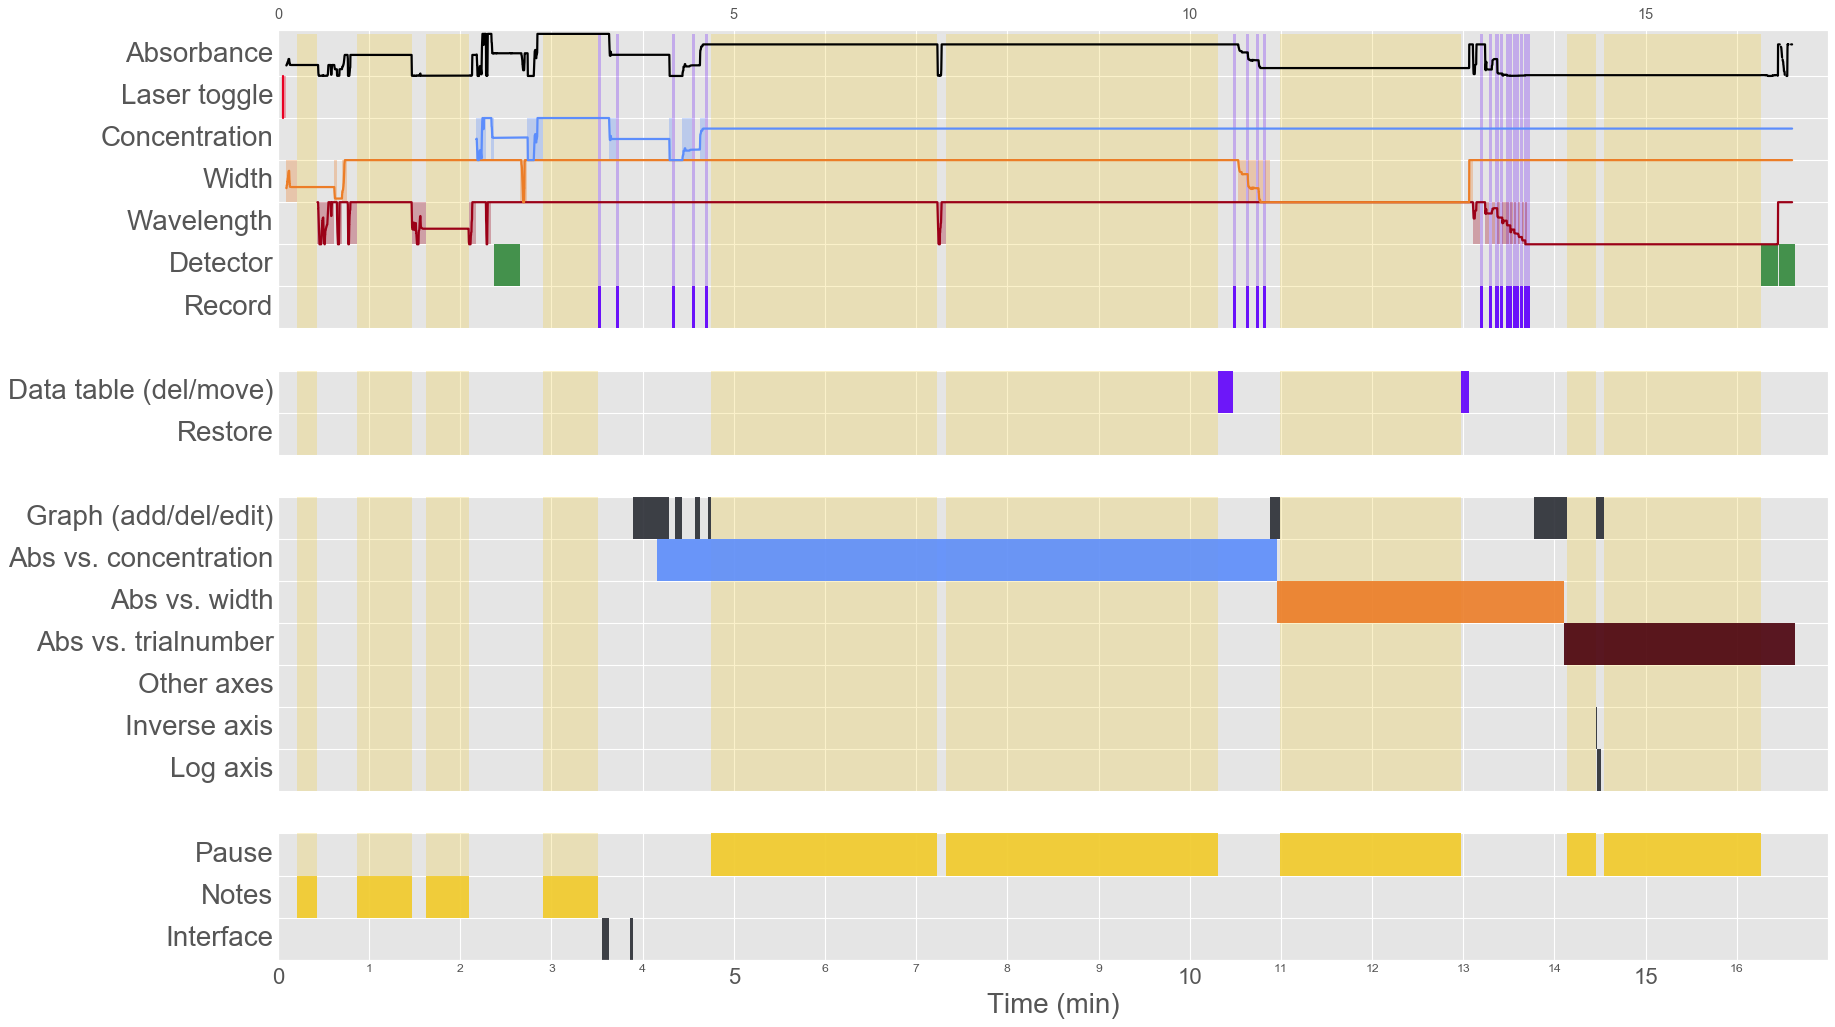

In [6]:
studentid = '90447168';sim = 'beers'
#high pre to high post
#cdw = 333->321
parsed_file = 'dream_table_beers-law-lab_90447168_2017-01-17_11.22.45.txt'
df = prep_parsing_data(parsed_file)
plot(df,to_plot,family_name_to_code,function_to_use,colors)

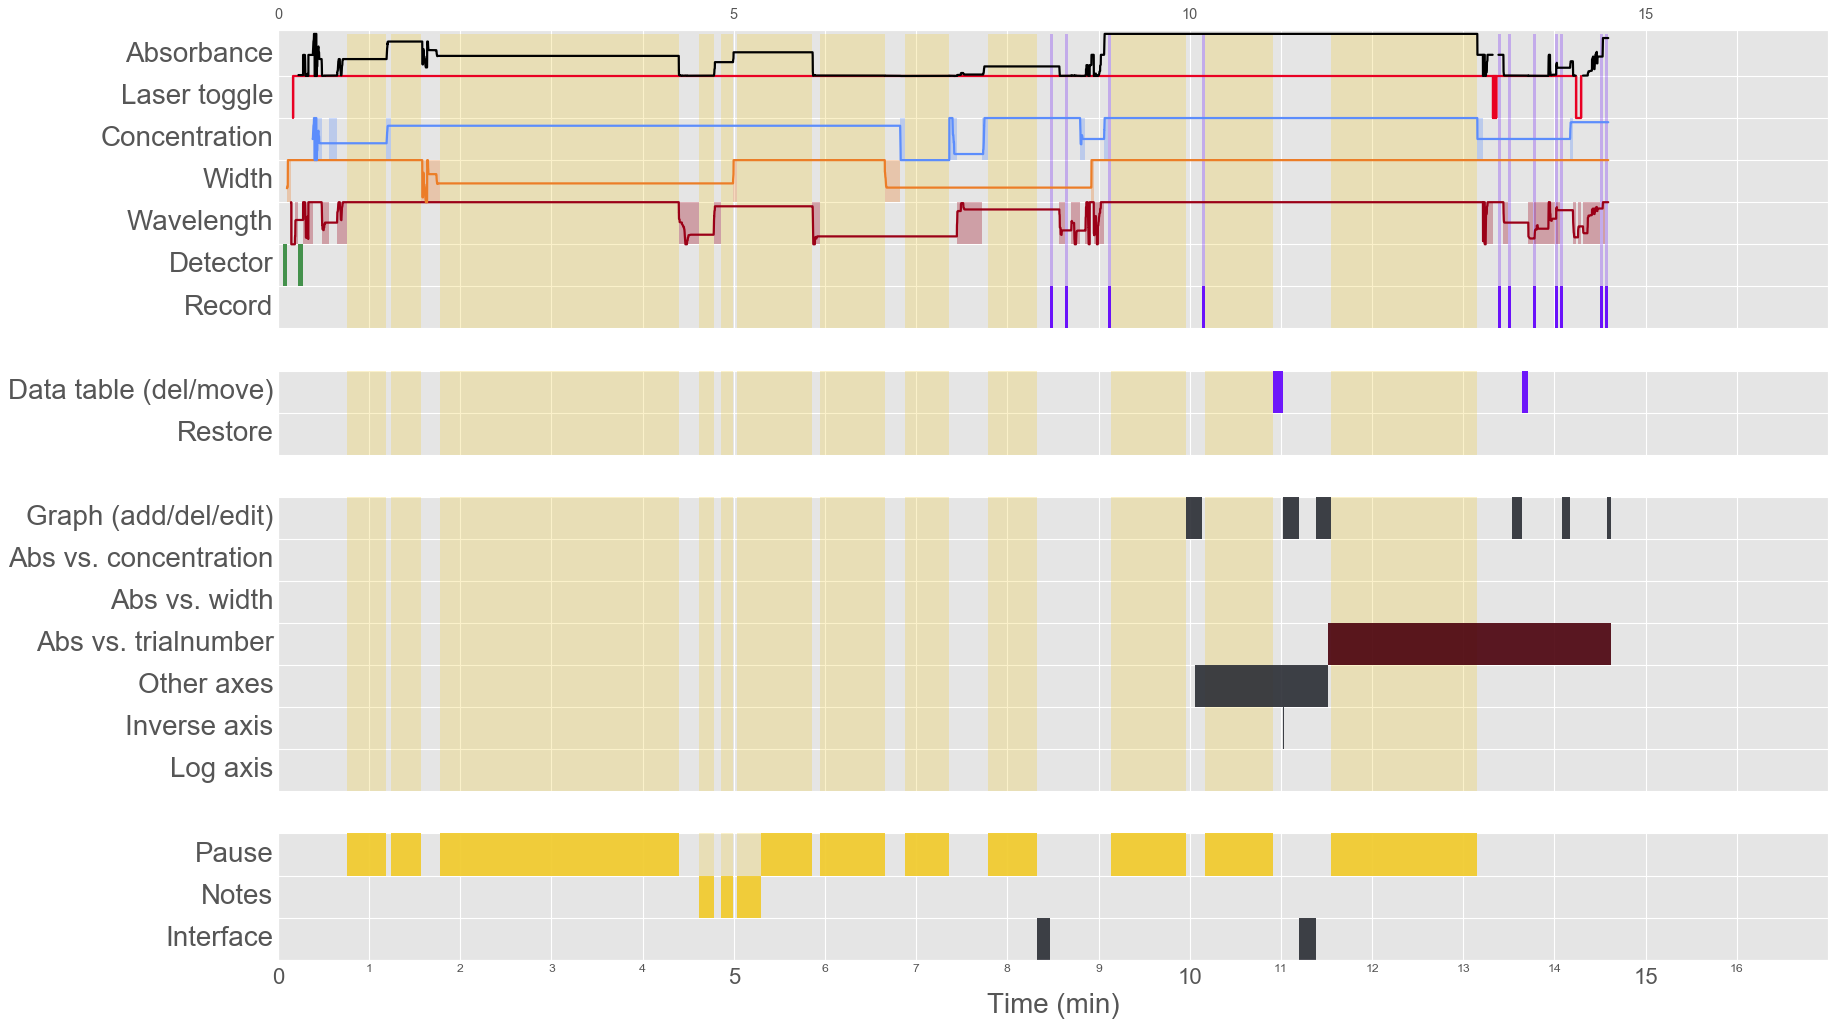

In [7]:
studentid = '19566168';sim = 'beers'
#cdw = 101->222
parsed_file = 'dream_table_beers-law-lab_19566168_2017-01-27_13.27.13.txt'
df2 = prep_parsing_data(parsed_file)
plot(df2,to_plot,family_name_to_code,function_to_use,colors)

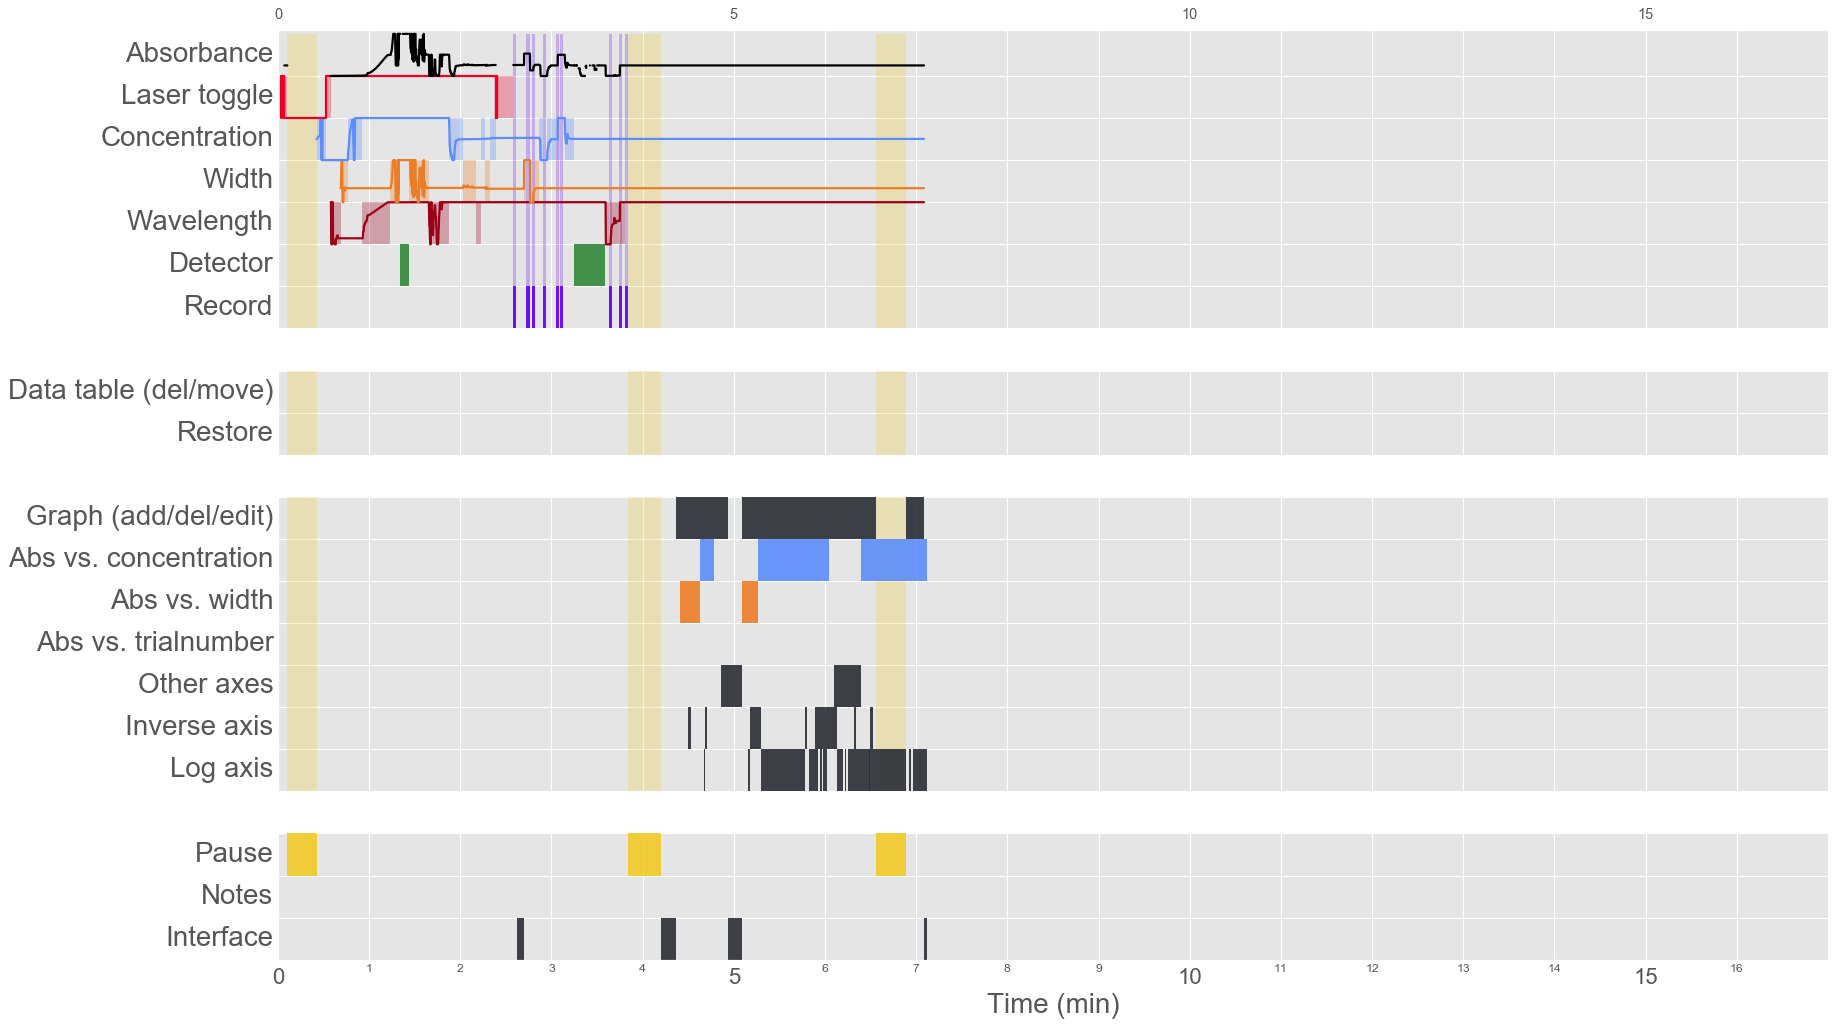

In [8]:
studentid = '12263156';sim = 'beers'
#main, cdw = 111
parsed_file = 'dream_table_beers-law-lab_12263156_2017-01-20_15.25.01.txt'
df3 = prep_parsing_data(parsed_file)
plot(df3,to_plot,family_name_to_code,function_to_use,colors)

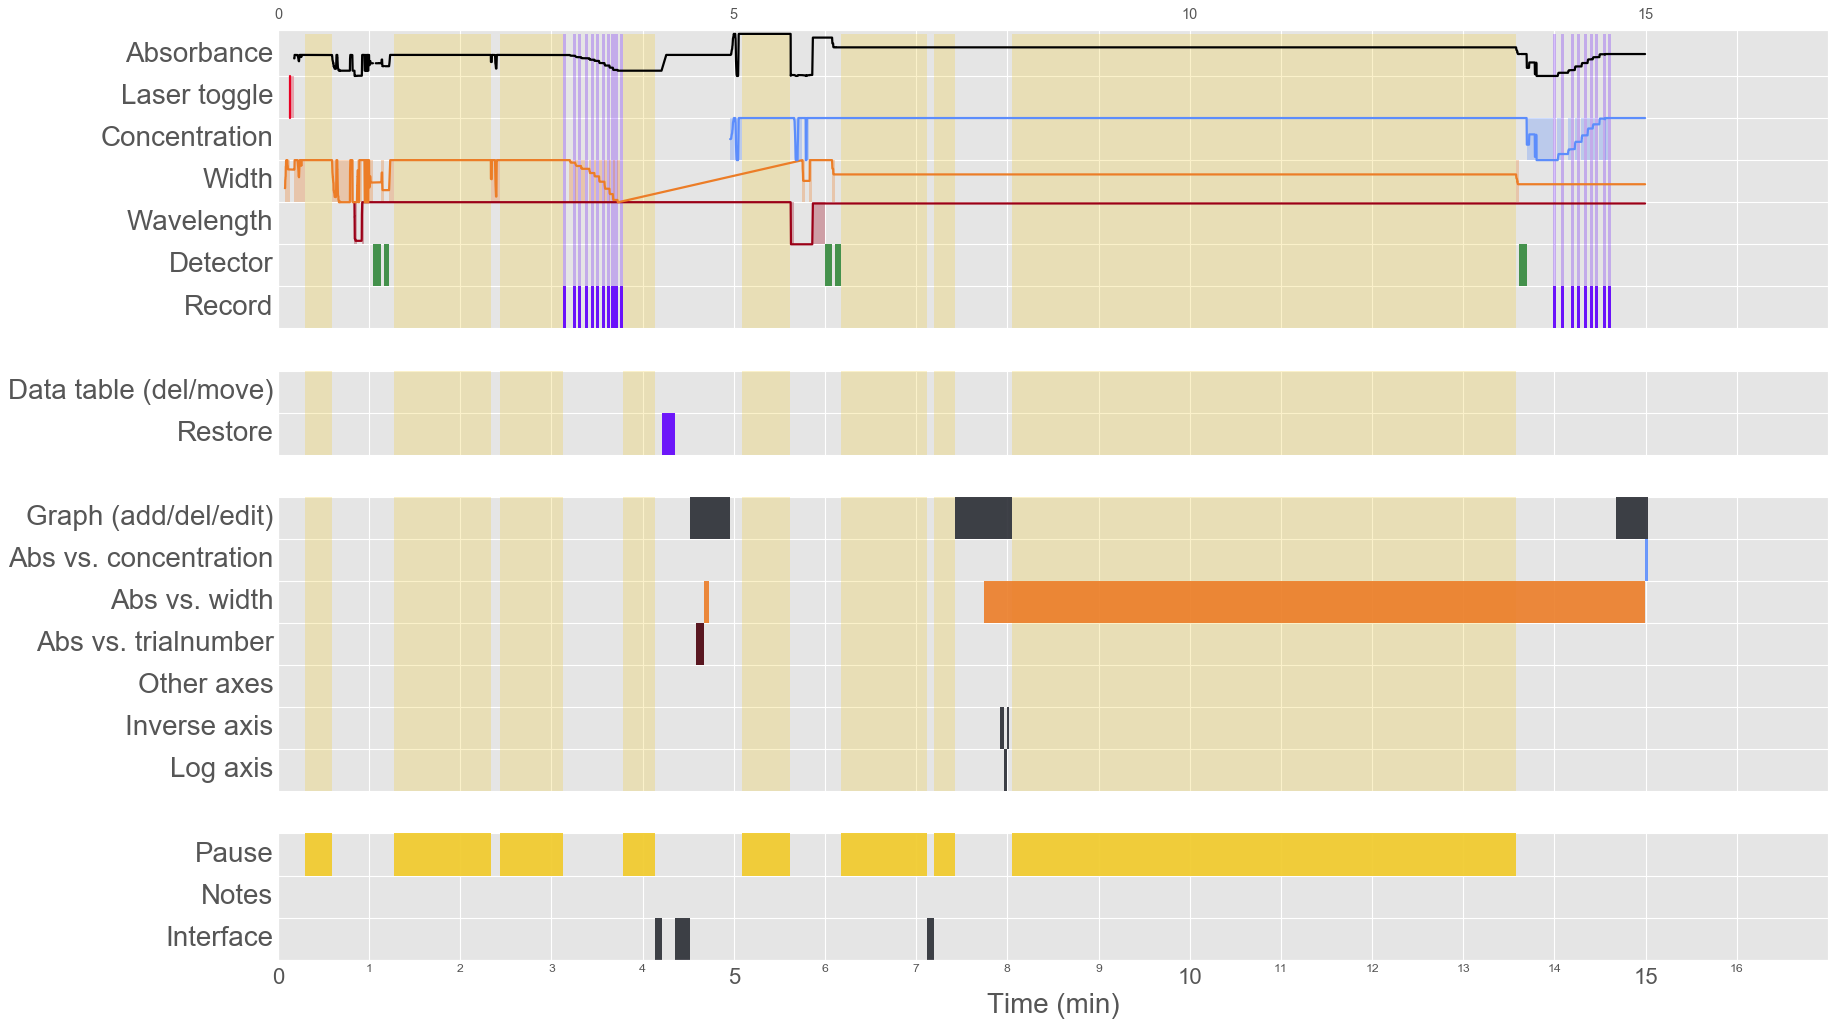

In [9]:
studentid = '16317166'
#main, cdw = 231
parsed_file = find_student_log_file(sim,studentid,date='2017-03-21_17.28.42')
df4 = prep_parsing_data(parsed_file)
plot(df4,to_plot,family_name_to_code,function_to_use,colors)